In [1]:
"""
Transform accumulated changes from fMRI layers into durations (s) using
multiclass SVM
"""

'\nTransform accumulated changes from fMRI layers into durations (s) using\nmulticlass SVM\n'

# IMPORT LIBS AND DATA 

In [2]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.io as sio
import scipy.stats as stats
import os.path as op
import os
from sklearn.base import clone
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
# import pymc3 as pm

outdir = 'D:\\ERICK\\MD\\prediction_data\\'
datadir = 'D:\\ERICK\\MD\\'
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

# SVM

In [1]:
# RESTING-STATE NETWORKS
#create training data from salient events
resdir = 'D:\\ERICK\\MD\\Results\\'
excluded = [41, 45] # corrupted data
regions = ['rNet1', 'rNet2', 'rNet3', 'rNet6', 'rNet7', 'rNet8', 'rNet11']
netKey = {
    'rNet1': 'vis',
    'rNet2': 'smn',
    'rNet3': 'cing',
    'rNet6': 'dmn',
    'rNet7': 'fpn',
    'rNet8': 'aud',
#     'rNet9': 'aud2',
    'rNet11': 'dan',
}
regions = [netKey[reg] for reg in regions]

for i, tmax in enumerate(np.linspace(0, 3, 50)):
    if tmax % 1 == 0:
        tmax = int(tmax)
    for j, tmin in enumerate(np.linspace(-3,0,50)):
        print('----------------------------------------------')
        print(f'tmax = {tmax} and tmin = {tmin}')
        if tmin % 1 == 0:
            tmin = int(tmin)
        for region in regions:
            new_id = 1
            df_region = []
            save_dir = op.join(outdir, 'Robustness', str(i+1), str(j+1))
            save_path = op.join(save_dir, '{}.csv'.format(region))
            if not op.isdir(save_dir):
                os.makedirs(save_dir)
            for subject in range(4, 45):
                if subject in excluded:
                    continue
                data_net = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': [], 'estimationError': []}
                for rd_max in range(3, 7):
                    for rd_min in range(3, 7):
                        text = f'tmax={np.round(tmax, rd_max)}_tmin={np.round(tmin, rd_min)}'
                        datafile = op.join(resdir, str(subject), 'Robustness', region,
                                           f'accum_changes_{region}_{text}.mat')

                        if op.isfile(datafile):

                            df = sio.loadmat(datafile)
                            df = df['d'][0][0]

                            h = len(df[0])
                            hb = data.loc[data['rawSubjID']==subject, 'humanBias']
                            error = data.loc[data['rawSubjID']==subject, 'estimationError']

                            data_net['subj'].extend([new_id] * h)
                            data_net['duration'].extend(df[4].reshape(h))
                            data_net['isCity'].extend(df[2].reshape(h))
                            data_net['report'].extend(df[1].reshape(h))
                            data_net['humanBias'].extend(hb)
                            data_net['estimationError'].extend(error)
                            data_net['acc_se'] = df[0].reshape(h)

                            new_df = pd.DataFrame(data_net)
                            df_region.append(new_df)
                            break 
                            
                    if op.isfile(datafile):    
                        break

                new_id = new_id + 1
            
            # Salvando
            df = pd.concat(df_region, ignore_index=True)
            df.to_csv(save_path, sep=',', encoding='utf-8')
            
# df_visual = pd.concat(df_visual, ignore_index=True)
# df_auditory = pd.concat(df_auditory, ignore_index=True)
# df_somatosensory = pd.concat(df_somatosensory, ignore_index=True)

In [2]:
# HIERARCHICAL DATA
#create training data from salient events
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)
resdir = 'D:\\ERICK\\MD\\Results\\'
excluded = [41, 45]
regions = {'visual': ['rLOC', 'rV1', 'rVO'], 'auditory': ['rBA1', 'rBA2', 'rBA3'], 'somatosensory': ['rBA22', 'rBA41', 'rBA42']}
layers = [1, 2, 3]

for i, tmax in enumerate(np.linspace(0, 3, 50)):
    if tmax % 1 == 0:
        tmax = int(tmax)
    for j, tmin in enumerate(np.linspace(-3,0,50)):
        print('----------------------------------------------')
        print(f'tmax = {tmax} and tmin = {tmin}')
        if tmin % 1 == 0:
            tmin = int(tmin)
        for region in regions:
            new_id = 1
            df_region = []
            save_dir = op.join(outdir, 'Robustness', str(i+1), str(j+1))
            save_path = op.join(save_dir, '{}.csv'.format(region))
            if not op.isdir(save_dir):
                os.makedirs(save_dir)
            for subject in range(4, 45):
                if subject in excluded:
                    continue
                    print(subject)
                data_layers = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': [], 'estimationError': []}
                for layer in layers:
                    for rd_max in range(3, 7):
                        for rd_min in range(3, 7):
                            text = f'tmax={np.round(tmax, rd_max)}_tmin={np.round(tmin, rd_min)}'
                            datafile = op.join(resdir, str(subject), 'Robustness', regions[region][layer-1],
                                               f'accum_changes_{regions[region][layer-1]}_{text}.mat')

                            if op.isfile(datafile):
                                
                                df = sio.loadmat(datafile)
                                df = df['d'][0][0]

                                h = len(df[0])
                                hb = data.loc[data['rawSubjID']==subject, 'humanBias']
                                error = data.loc[data['rawSubjID']==subject, 'estimationError']

                                if layer==1:
                                    data_layers['subj'].extend([new_id] * h)
                                    data_layers['duration'].extend(df[4].reshape(h))
                                    data_layers['isCity'].extend(df[2].reshape(h))
                                    data_layers['report'].extend(df[1].reshape(h))
                                    data_layers['humanBias'].extend(hb)
                                    data_layers['estimationError'].extend(error)
                                data_layers['l{}'.format(layer)] = df[0].reshape(h)
                                break 

                        if op.isfile(datafile):    
                            break

                new_df = pd.DataFrame(data_layers)
                df_region.append(new_df)
                new_id = new_id + 1
            
            # Salvando
            df = pd.concat(df_region, ignore_index=True)
            df.to_csv(save_path, sep=',', encoding='utf-8')
            
# df_visual = pd.concat(df_visual, ignore_index=True)
# df_auditory = pd.concat(df_auditory, ignore_index=True)
# df_somatosensory = pd.concat(df_somatosensory, ignore_index=True)

In [32]:
data

,Unnamed: 0,subj,duration,isCity,report,humanBias,estimationError,predicted,l1,l2,l3
0,0,1.0,24.0,0.0,29.5,97.654941,5.5,22.787646,21.0,19.0,19.0
1,1,1.0,16.0,1.0,14.7,38.461538,1.3,15.648651,13.0,14.0,13.0
2,2,1.0,20.0,0.0,18.4,61.050328,1.6,18.656014,16.0,17.0,15.0
3,3,1.0,8.0,1.0,9.8,72.941176,1.8,8.291380,7.0,7.0,6.0
4,4,1.0,8.0,0.0,3.1,-45.294118,4.9,7.720214,6.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
2206,2206,40.0,8.0,0.0,6.1,-36.513443,1.9,7.720214,6.0,6.0,6.0
2207,2207,40.0,24.0,0.0,23.6,15.168768,0.4,24.099038,20.0,21.0,22.0
2208,2208,40.0,24.0,1.0,23.8,16.144774,0.2,23.697136,20.0,21.0,21.0
2209,2209,40.0,12.0,1.0,11.3,7.704527,0.7,12.785868,11.0,10.0,11.0


In [3]:
data_type = 'hierarchical'
if data_type == 'hierarchical':
    files = ["visual", "auditory","somatosensory"]
elif data_type == 'rs_nets':
    files = ['vis', 'smn', 'cing', 'dmn', 'fpn', 'aud', 'dan']
    
for i, tmax in enumerate(np.linspace(0, 3, 50)):
    for j, tmin in enumerate(np.linspace(-3, 0, 50)):
        print(f'tmax: {i+1} and tmin: {j+1}')
        for region in files:
            print(region)
            load_file = op.join(outdir, 'Robustness', str(i+1), str(j+1), '{}.csv'.format(region))
            save_file = op.join(outdir, 'Robustness', str(i+1), str(j+1), 'predicted_{}.csv'.format(region))
            if not op.isfile(save_file):
                print(save_file)
                data = pd.read_csv(load_file, sep=',')
                if data_type == 'hierarchical':
                    accumulated_changes = np.array(pd.concat([data.l1 , data.l2, data.l3],axis=1))
                elif data_type == 'rs_nets':
                    accumulated_changes = np.array(data.acc_se).reshape(-1, 1)
     
                duration=np.ravel(data.duration)
                regressor = SVR(kernel='rbf', C=1e3, gamma=0.0001)
                regressor.fit(accumulated_changes, duration)
                predicted = regressor.predict(accumulated_changes)
                if data_type == 'hierarchical':
                    output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report, data.humanBias, data.estimationError,
                                    pd.Series(predicted), data.l1,data.l2,data.l3],axis=1))
                    output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'humanBias', 'estimationError', 
                                           'predicted','l1', 'l2', 'l3'])
                elif data_type == 'rs_nets':
                    output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report, data.humanBias,
                                                    pd.Series(predicted), data.acc_se],axis=1))
                    output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'humanBias', 'predicted', 'acc_se'])
                output.to_csv(save_file, sep=',', encoding='utf-8')

In [4]:
#calculate model bias for each subject
data_type = 'hierarchical'
if data_type == 'hierarchical':
    files = ["visual", "auditory","somatosensory"]
elif data_type == 'rs_nets':
    files = ['vis', 'smn', 'cing', 'dmn', 'fpn', 'aud', 'dan']
    
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
excluded = [36, 40] #considerando novo id

for i, tmax in enumerate(np.linspace(0, 3, 50)):
    for j, tmin in enumerate(np.linspace(-3, 0, 50)):
        print(f'tmax: {i+1} and tmin: {j+1}')
        if data_type == 'hierarchical':
            modelBias_off = {'visual':[], 'auditory':[], 'somatosensory':[]}
            modelBias_city = {'visual':[], 'auditory':[], 'somatosensory':[]}
            avgmb_diff = {'visual':[], 'auditory':[], 'somatosensory':[]}
            modelBias_all = {'visual':[], 'auditory':[], 'somatosensory':[]}
            avgmb_all = {'visual':[], 'auditory':[], 'somatosensory':[]}
            avgmb_c = {'visual':[], 'auditory':[], 'somatosensory':[]}
            avgmb_o = {'visual':[], 'auditory':[], 'somatosensory':[]}
        elif data_type == 'rs_nets':
            modelBias_off = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            modelBias_city = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            avgmb_diff = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            modelBias_all = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            avgmb_all = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            avgmb_c = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
            avgmb_o = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[]}
        n = 40  # Tamanho da amostra
        # outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

        for region in files:
            print(region)
            load_file = op.join(outdir, 'Robustness', str(i+1), str(j+1), 'predicted_{}.csv'.format(region))
            data = pd.read_csv(load_file)
            for subj in range(1, 41):
                subset_c = data.loc[(data['subj'] == subj) & (data['isCity'] == 1)]
                subset_o = data.loc[(data['subj'] == subj) & (data['isCity'] == 0)]
                subset = data.loc[(data['subj'] == subj)]
                mb_subcity = []
                mb_suboff = []
                mb_suball = []

                for dur in durations:
                    mean_dur = subset.groupby('duration')['predicted'].mean().tolist()
                for ind, row in subset.iterrows():
                    modelrep = row['predicted']
                    md_idx = dur_dic[row['duration']]
                    model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                    mb_suball.append(model_bias)
                    modelBias_all[region].append(model_bias)
                for ind, row in subset_c.iterrows():
                    modelrep = row['predicted']
                    md_idx = dur_dic[row['duration']]
                    model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                    mb_subcity.append(model_bias)
                    modelBias_city[region].append(model_bias)
                for ind, row in subset_o.iterrows():
                    modelrep = row['predicted']
                    md_idx = dur_dic[row['duration']]
                    model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                    mb_suboff.append(model_bias)
                    modelBias_off[region].append(model_bias)
                    
                #calculate diff
                diff = np.mean(mb_subcity)-np.mean(mb_suboff)
                avgmb_diff[region].append(diff)
                avgmb_c[region].append(np.mean(mb_subcity))
                avgmb_o[region].append(np.mean(mb_suboff))
                avgmb_all[region].append(np.mean(mb_suball))

            #overwrite file
            data['modelBias'] = modelBias_all[region]
            data.to_csv(load_file, sep=',', encoding='utf-8')

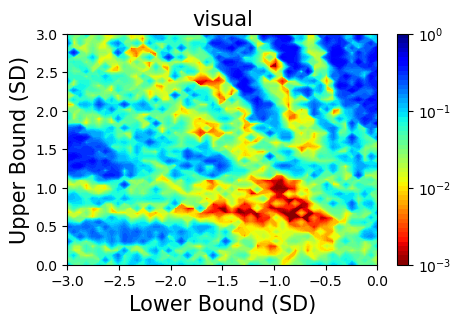

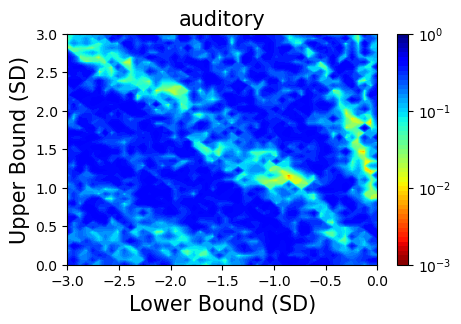

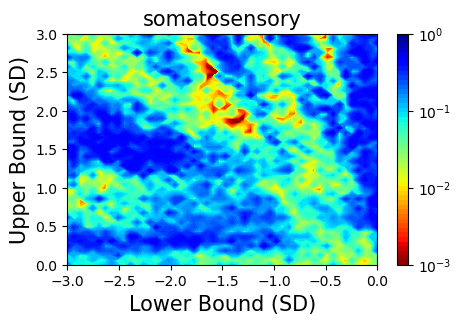

In [109]:
import seaborn as sns
import matplotlib.colors as mcolors
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
# files = {'vis': 'visual', 'smn': 'somatomotor', 'cing': 'cingulo-opercular', 'dmn': 'default mode', 
#          'fpn': 'frontoparietal', 'aud': 'auditory', 'dan': 'dorsal-attention'}
files = {'vis':"visual", 'aud':"auditory", 'smn':"somatosensory"}
excluded = [40]
sig_fraction = {}
corrs = {}

for region in files: 
    sig_count = 0
    total_count = 0
    heatmap = {'tmax': [], 'tmin': [], 'p-value': []}
    corr_list = []
    for i, tmax in enumerate(np.linspace(0, 3, 50)):
        for j, tmin in enumerate(np.linspace(-3, 0, 50)):
            total_count += 1
            heatmap['tmax'].append(tmax)
            heatmap['tmin'].append(tmin)
            model_file = op.join(outdir, 'Robustness', str(i+1), str(j+1), 'predicted_{}.csv'.format(region))
            model_data = pd.read_csv(model_file)
            mask = model_data['subj'].isin(excluded)
            model_data = model_data[~mask]

            #Regressão => bias (human) = B0 + B1 * bias (model)
            x = model_data['modelBias']
            y = model_data['humanBias']
            rho, p = stats.pearsonr(x, y)
            modelo = sm.OLS(y, sm.add_constant(x)).fit()
            p_value = modelo.f_pvalue/2
            beta = modelo.params.iloc[1]
            
            if p_value < 0.001:
                p_value = 0.001
            if p_value < 0.05 and beta>0 :
                sig_count += 1
                corr_list.append(rho)
            heatmap['p-value'].append(p_value)

    hm = pd.DataFrame(heatmap)

    fig, ax = plt.subplots(figsize=(5, 3))

    tmax_vals = np.linspace(0, 3, 50)
    tmin_vals = np.linspace(-3, 0, 50)
    pvalue_matrix = np.reshape(hm['p-value'].values, (50, 50))

    contourf = ax.contourf(tmin_vals, tmax_vals, pvalue_matrix, cmap='jet_r', levels=np.logspace(-3, 0, 51), norm=mcolors.LogNorm())
    cbar = plt.colorbar(contourf) 
    cbar.set_ticks([0.001, 0.01, 0.1, 1])

    ax.set_title(files[region], fontsize=15)
    ax.set_ylabel('Upper Bound (SD)', fontsize=15)
    ax.set_xlabel('Lower Bound (SD)', fontsize=15)
 
    plt.show()
    
    sig_fraction[files[region]] = sig_count/total_count
    corrs[files[region]] = corr_list
#     print('Fraction of ssig_count_countificant values:', sig_fraction)

C:\Users\erick\AppData\Local\Temp\ipykernel_21284\4089009011.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cividis', len(files))


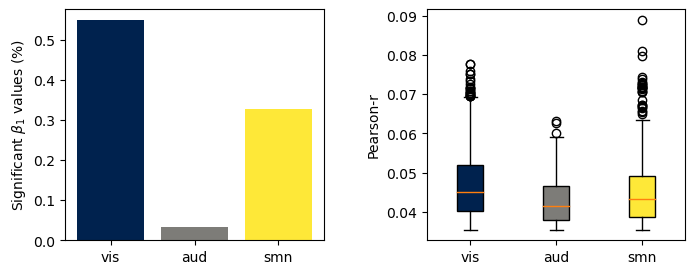

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
corrs_data = [corrs[files[region]] for region in files]

# Criar uma paleta de cores (ex: viridis com 3 cores)
cmap = plt.cm.get_cmap('cividis', len(files))
colors = [cmap(i) for i in range(len(files))]

for i, region in enumerate(files):
    axs[0].bar(region, sig_fraction[files[region]], label=region, color=colors[i])
    
box = axs[1].boxplot(corrs_data, labels=files, patch_artist=True)

# Adicionar cores diferentes às caixas do boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
axs[0].set_ylabel('Significant $\\beta_1$ values (%)')
axs[1].set_ylabel('Pearson-r')
plt.subplots_adjust(wspace=0.4)

In [111]:
sig_fraction

{'visual': 0.5492, 'auditory': 0.0332, 'somatosensory': 0.328}

# FIG 5

In [34]:
import warnings
warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ["visual","auditory","somatosensory"]
columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)

for region in files: 
    print('--------------------------------')
    print(region)
    model_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)
    
#     #plot model bias hist
#     plt.hist(model_data['modelBias'])
#     plt.show()
    
    #Regressão => bias (human) = B0 + B1 * bias (model)
    x = model_data['modelBias']
    y = model_data['humanBias']
    #corr
    rho,p = stats.spearmanr(x, y)
    print('Correlation between human and model bias: r = {:.2f}, p = {:.3f}'
          .format(rho, p))
    modelo = sm.OLS(y, sm.add_constant(x)).fit()
    print('Linear Regression between human and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'
          .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))
    
    #EFEITO FIXO = MODEL BIAS
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = -2 * (llf_reduced - llf_full)
    # Calcular o valor p do teste
    p_value = chi2.sf(lrt, 1)
    print('Using model bias as fixed effect: chi-sqr = {:.2f}, p = {:.3f}'
          .format(lrt, p_value))
    
    #EFEITO FIXO = CENA
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = np.round(-2 * (llf_reduced - llf_full), 2)
    # Calcular o valor p do teste
    p_value = np.round(chi2.sf(lrt, 1), 3)
    #calculate and print statistics
    mean = np.round(np.mean(avgmb_diff[region]), 2)
    SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = np.round(mean - (z * SE), 2)
    upper_bound = np.round(mean + (z * SE), 2)
    print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
          .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
    linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
    df.loc[len(df)] = linha
    
outFile = op.join(outdir, 'lmm_table_rep.csv')
df.to_csv(outFile, sep=',', encoding='utf-8')

--------------------------------
visual
Correlation between human and model bias: r = 0.06, p = 0.007
Linear Regression between human and model bias: beta = 0.13 ± 0.06, p = 0.030
Using model bias as fixed effect: chi-sqr = 0.87, p = 0.351
Using scene as fixed effect: M±SEdiff = 4.13 ± 0.53 (normalized bias, %), 95% CI [3.09, 5.17], chi-sqr = 77.30, p = 0.000
--------------------------------
auditory
Correlation between human and model bias: r = 0.01, p = 0.747
Linear Regression between human and model bias: beta = -0.05 ± 0.07, p = 0.524
Using model bias as fixed effect: chi-sqr = -3.02, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.16 ± 0.42 (normalized bias, %), 95% CI [-0.66, 0.98], chi-sqr = -0.01, p = 1.000
--------------------------------
somatosensory
Correlation between human and model bias: r = 0.00, p = 0.824
Linear Regression between human and model bias: beta = 0.02 ± 0.07, p = 0.816
Using model bias as fixed effect: chi-sqr = -3.53, p = 1.000
Using scene as fixed ef

In [5]:
# import warnings
# warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
# files = ["visual","auditory","somatosensory"]
# columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
# df = pd.DataFrame(columns=columns)

# for region in files: 
#     print(region)
#     model_file = op.join(outdir, 'predicted_{}.csv'.format(region))
#     model_data = pd.read_csv(model_file)
#     #plot model bias hist
#     plt.hist(model_data['modelBias'])
#     plt.show()
    
#     orig_file = op.join(datadir, 'master_dataset.csv')
#     orig = pd.read_csv(orig_file)
#     model_data['humanBias'] = orig['humanBias']
    
#     #EFEITO FIXO = MODEL BIAS
#     vc = {'subj': '1 + C(subj)'}
#     # Ajustar o modelo reduzido sem o efeito fixo
#     model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
#     result_reduced = model_reduced.fit()
#     # Ajustar o modelo completo com o efeito fixo
#     model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
#     result_full = model_full.fit()
#     # Calcular a diferença nas log-verossimilhanças
#     llf_full = result_full.llf
#     llf_reduced = result_reduced.llf
#     lrt = -2 * (llf_reduced - llf_full)
#     # Calcular o valor p do teste
#     p_value = chi2.sf(lrt, 1)
#     #calculate and print statistics
#     mean = np.mean(avgmb_all[region])
#     SE = np.std(avgmb_all[region], ddof=1)/np.sqrt(n)    
#     z = 1.96  # Valor crítico para um intervalo de confiança de 95%
#     lower_bound = mean - (z * SE)
#     upper_bound = mean + (z * SE)
#     print('Using model bias as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
#           .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
#     #EFEITO FIXO = CENA
#     vc = {'subj': '1 + C(subj)'}
#     # Ajustar o modelo reduzido sem o efeito fixo
#     model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
#     result_reduced = model_reduced.fit()
#     # Ajustar o modelo completo com o efeito fixo
#     model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
#     result_full = model_full.fit()
#     # Calcular a diferença nas log-verossimilhanças
#     llf_full = result_full.llf
#     llf_reduced = result_reduced.llf
#     lrt = np.round(-2 * (llf_reduced - llf_full), 2)
#     # Calcular o valor p do teste
#     p_value = np.round(chi2.sf(lrt, 1), 3)
#     #calculate and print statistics
#     mean = np.round(np.mean(avgmb_diff[region]), 2)
#     SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
#     z = 1.96  # Valor crítico para um intervalo de confiança de 95%
#     lower_bound = np.round(mean - (z * SE), 2)
#     upper_bound = np.round(mean + (z * SE), 2)
#     print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
#           .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
#     linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
#     df.loc[len(df)] = linha
    
# outFile = op.join(outdir, 'lmm_table_original.csv')
# df.to_csv(outFile, sep=',', encoding='utf-8')